# Monte Carlo Techniques for Engineering under Uncertainty: Cable Example

This is an introduction to using Monte Carlo techniques to predict the distribution of performance of an engineered system. We will use a simple toy example to get started. This simple example has an analytical solution, which we will check the Monte Carlo results against.

## The Cable Example
Our simple example will be the failure probability of a cable loaded in tension. Imagine we are designing a crane, and this cable will be used to suspend the crane's load. If the cable fails, the crane will drop its load - our customer will be very upset, and someone could get hurt! So it's very important that we understand how likely these failures are to occur for a given design.

### Inputs, Outputs and the Performance Model
Our cable model has two *input parameters* - the strength of the cable, $s$, and the maximum load on the cable, $w$. The cable model has a single *output parameter* - the cable's margin to failure, $m$. The cable fails if $m < 0$. The *performance model* is a function mapping the inputs to outputs is:

$$ m = f(s, w) = s - w $$

All the parameters have units of tons, but we'll sometimes drop the units for simplicity.

### Input distributions
In a typical point-design, we would assign a single, deterministic value to each of the input parameters, and then evaluate the model to check its performance at the design point. For example, we could assume the crane needs to support a load of 85 tons, and select a 100 ton cable. We then evaluate the performance model, and find that the cable margin is +15 tons. We're off to the races!

However, we typically are uncertain about the exact values of the inputs to our performance model. This may be due to imperfect knowledge (perhaps we're unsure how the customer plans to use the crane) or stochastic processes underlying the input parameters (perhaps there are random variations in the quality of the cables). In either case, our approach is to represent the input parameters as random variables with some probability distribution. Suppose we test a sample of cables, and find that their strength is normally distributed around 100 tons with a 5 ton standard deviation. We also survey users of similar cranes, and find that the maximum load they put on their cranes is normally distributed around 85 tons with a standard deviation of 10 tons. We also believe that the strength and load are independent of each other. Thus, the input distribution is:

$$ s \sim \mathcal{N}_1(\mu_s \sigma_s^2), \quad \mu_s = 100, \sigma_s = 5 $$
$$ w \sim \mathcal{N}_1(\mu_w, \sigma_w^2), \quad \mu_w = 85, \sigma_s = 10 $$
$$ s \perp w $$

### Output Distribution: Analytic solution
Given the uncertainty in the input parameters, we cannot definitively predict the performance of the system. Instead, we also represent the output parameter as a random variable, and examine its distribution in order to predict the performance of the system. For example, we want to know 1) what is the expected margin in the cable, and 2) what is the probability of cable failure?

In this simple example, we can find an analytic solution. The margin $m$ is a linear combination of Normal random variables, and is thus also Normal. The distribution of $m$ is:

$$ m \sim \mathcal{N}_1(\mu_m, \sigma_m^2) $$
$$ \mu_m = \mu_s  - \mu_w = 15 $$
$$ \sigma_m^2 = \sigma_s^2 + \sigma_w^2 \quad \rightarrow \quad \sigma_m = 11.18 $$

The expected margin is 15 tons. The probability of failure is:

$$ P(fail) = P( m < 0) $$

$$ P(fail) = F_{\mathcal{N}(0,1)} \left( - \frac{\mu_m}{\sigma_m} \right) $$

where $F_{\mathcal{N}(0,1)}$ is the cumulative distribution function of the standard normal distribution. We can look up its value in tables, or compute it using scipy's `stats` module:


In [1]:
from scipy import stats

# Paramters of the cable strength distribution
strength_mean = 100.
strength_sd = 5.

# Paramters of the load distribution
load_mean = 85.
load_sd = 10.

# Compute the parameters of the margin (strength - load) distribution.
m_mean = strength_mean - load_mean
m_sd = (strength_sd**2 + load_sd**2)**0.5

m_rv = stats.norm(loc=m_mean, scale=m_sd)

# Compute the probability of failure from the cdf
p_fail = m_rv.cdf(0)
print('Analytic failure probability: {:.4f}'.format(p_fail))

Analytic failure probability: 0.0899


There is about a 9% chance that the cable will fail with this design.

## The General Performance Uncertainty Problem

Let's step back and consider the general performance uncertainty problem. We are considering the performance of a system with uncertain driving factors. We choose to measure the performance of the system with a collection of *output parameters*, $y$. The performance is driven by a collection of *input parameters*, $x$. We have devised a *performance model* of the system, $f$, which predicts the output parameters given a particular value of the input parameters:

$$ y =  f(x) $$

We assume that the performance model is deterministic: for any input, it always gives the same output.

We are. however, uncertain about the value of the input, and thus $x$ is a random variable But we do have some knowledge about the distribution of the input parameters, $\mathcal{D}_x$:

$$ x \sim \mathcal{D}_x $$

The performance of the system is also a random variable, and follows some unknown distribution $\mathcal{D}_y$:

$$ y \sim \mathcal{D}_y $$

The performance uncertainty problem is: Given a performance model $f$ and an input distribution $\mathcal{D}_x$, estimate the output distribution $\mathcal{D}_y$.

In the simple cable example, we can solve for the output distribution $\mathcal{D}_y$ analytically. However, in real problems, $f$ and $\mathcal{D}_x$ are more complicated, and we cannot find an analytic solution. We might not even have a closed-form solution for $f$ - perhaps it is modeled by some complex numerical procedure. Or perhaps we do not know the pdf/cdf of $\mathcal{D}_x$, and instead just have a collection of samples from it.

Nonetheless, we can estimate $\mathcal{D}_y$ with the Monte Carlo method, as long we can evaluate $f$ and sample from $\mathcal{D}_x$.


## The Monte Carlo Method
Monte Carlo methods are computational techniques which estimate a distribution by simulating many samples from it. In the context of engineering uncertainty, we can use Monte Carlo methods to estimate the distribution of system performance, even if the relation of uncertain inputs to performance is very complicated. In essence, we use simulation to generate a sample from the output distribution, and then estimate properties of the output distribution from that sample.

The method has 3 steps:
  1. *Sampling* - Draw a random sample of inputs $X$ from the input distribution $\mathcal{D}_x$. Each input value $x$ in the sample is called a *scenario*.
  2. *Simulation* - For each input scenario $x$ in the sample $X$, evaluate the performance model $f(x)$. This yields $Y = {y = f(x) for x \in X}$, which is a sample from the output distribution.
  3. *Analysis* - Compute statistics on the output sample $Y$, and use these statistics to infer properties of the output distribution $\mathcal{D}_y$.

## Monte Carlo Simulation of the Cable Example

Let's use Monte Carlo techniques on the cable example, and see if we can replicate the analytical solution. We'll use the Rhodium package to perform sampling. First, we set up the model in Rhodium.


In [2]:
import rhodium as rdm

# Define the model
def rod_model(strength=strength_mean, load=load_mean):
    margin = strength - load
    return margin

model = rdm.Model(rod_model)

model.parameters = [
    rdm.Parameter('strength'),
    rdm.Parameter('load'),
]

model.responses = [
    rdm.Response('margin', rdm.Response.MAXIMIZE)
]

model.uncertainties = [
    rdm.NormalUncertainty('strength', mean=strength_mean, stdev=strength_sd),
    rdm.NormalUncertainty('load', mean=load_mean, stdev=load_sd),
]

Next, we draw a sample of 1000 scenarios from the input distribution.


In [3]:
# Sample scenarios from the input distribution
scenarios = rdm.sample_lhs(model, nsamples=1000)

Then, we evaluate the performance model on each scenario (simulation):

In [4]:
# Evaluate the model at each scenario
results = rdm.evaluate(model, scenarios)

 Now, we can examine the results and estimate the failure probability. Simply use the fraction of the sample scenarios with $m < 0$ as an estimator of the failure probability:

In [6]:
import numpy as np

m_sample = np.array(results['margin'])

# Compute the failure probability
p_fail_mc = sum(m_sample < 0) / len(m_sample)
print('Monte-Carlo failure probability: {:.4f}'.format(p_fail_mc))

Monte-Carlo failure probability: 0.0990


This estimate is reasonably close to the analytic solution. Let's also plot the analytic and Monte-Carlo estimated output distributions and see how they compare

<IPython.core.display.Javascript object>


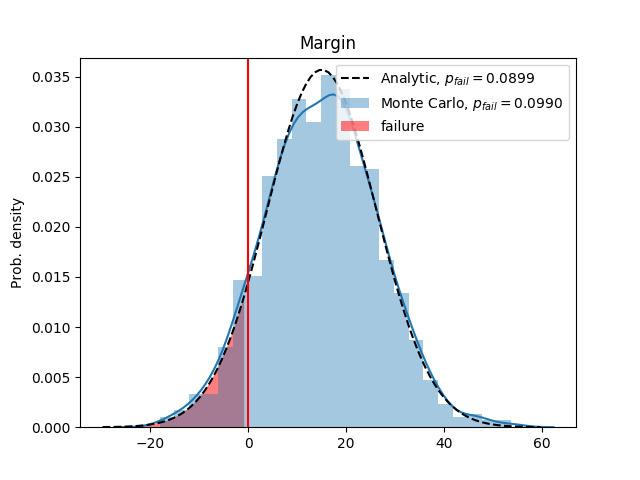

/home/mvernacc/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 0.036891885485282896)

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

sns.distplot(results['margin'], label='Monte Carlo, $p_{{fail}}={:.4f}$'.format(p_fail_mc))

x = np.linspace(m_mean - 4 * m_sd, m_mean + 4 * m_sd, 100)
plt.plot(x, m_rv.pdf(x), linestyle='--', color='black',
    label='Analytic, $p_{{fail}}={:.4f}$'.format(p_fail))
plt.fill_between(x[x <= 0], 0, m_rv.pdf(x[x <= 0]), facecolor='red', alpha=0.5, label='failure')
plt.axvline(x=0, color='red')
plt.title('Margin')
plt.ylabel('Prob. density')
plt.legend()
plt.ylim([0, plt.ylim()[1]])

The Monte Carlo cable margin histogram closely matches the analytic cable margin pdf.

## Sensitivity Analysis and Regression

We are also interested in questions such as:
  - To which inputs is the system's performance most sensitive?
  - How does the system's performance vary with a particular input?

One-factor-at-a-time (OAT) variation is a basic sensitivity analysis technique, and can give us a rough indication of which parameters are responsible for most of the uncertainty in the output. This analysis is also referred to as a "Tornado Plot" in de Neufville & Scholtes.

In the cable example, the variance of margin is simply $ \sigma_m^2 = \sigma_s^2 + \sigma_w^2 $. $\sigma_w^2 > \sigma_s^2$, so the uncertainty in load, $w$, contributes more to the variation of margin than does the uncertainty of strength.

<IPython.core.display.Javascript object>


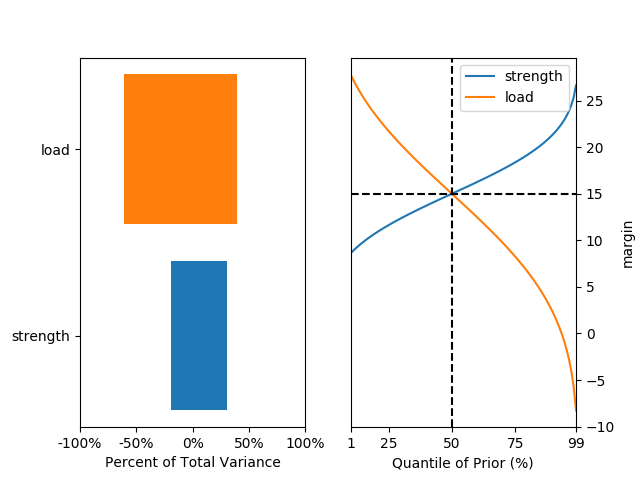

<IPython.core.display.Javascript object>


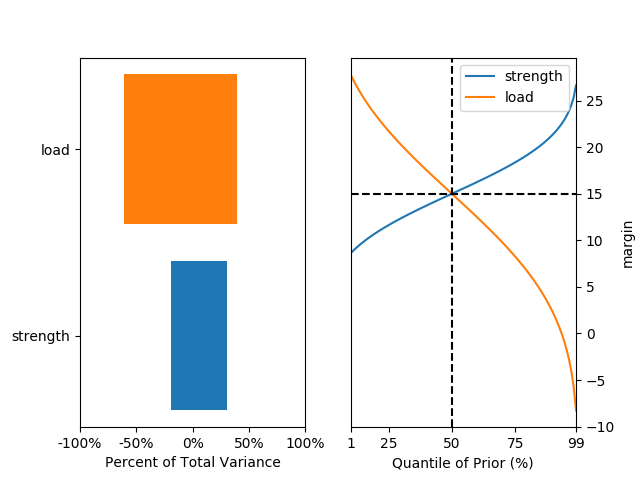

In [10]:
# One-factor-at-a-time sensitivity plot, aka tornado plot
rdm.oat(model, 'margin')

As expected, we see that the uncertainty in load is responsible for more of the variation in margin. The OAT method has some flaws, and more sophisticated measures of sensitivity are available (see *Sensitivity Analysis in Practice* by Satelli et al. and [SALib](https://salib.readthedocs.io/en/latest/index.html) ).

We can also examine how the output distribution changes as one of the input parameters is varied. We can visualize this interaction with what de Neufville and Scholtes call an "upside-downside plot" (I think "quantile plot" is a bit clearer).

<IPython.core.display.Javascript object>


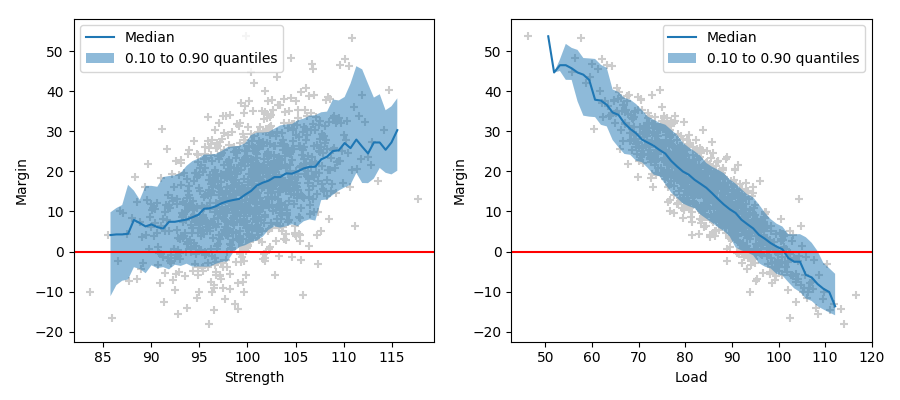

In [15]:
from quantile_plot import quantile_plot

# "Upside-downside plot" from de Neufville 
plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
quantile_plot(results['strength'], results['margin'], scatter=True, ax=ax1)
plt.xlabel('Strength')
plt.ylabel('Margin')
plt.axhline(y=0, color='red')
plt.legend()

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
quantile_plot(results['load'], results['margin'], scatter=True, ax=ax2)
plt.xlabel('Load')
plt.ylabel('Margin')
plt.axhline(y=0, color='red')
plt.legend()
plt.tight_layout()

Unsurprisingly, margin increases with strength and decreases with load. Also, the spread between the 0.10 and 0.90 quantiles of margin does not appear to vary with strength or with load. This indicates that margin is homoscedastic in both strength and load, i.e. $ V(m | s = s^*) $ is the same for any value of $s^*$, and $ V(m | s = w^*) $ is the same for any value of $w^*$. Indeed,

$$ V(m | s = s^*) = \sigma_w^2 \quad \forall s^* \in \mathbb{R} $$
$$ V(m | w = w^*) = \sigma_s^2 \quad \forall w^* \in \mathbb{R} $$

In more complicated models, this analysis may reveal heteroscedasticity. This would be interesting to discover, as it would alert us that we face more uncertainty in some regions of the input space than in others.